In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset  # Lectura y carga del dataset
from surprise import SVD  # Modelo: Singular Value Decomposition
from surprise import accuracy  # Métricas
from pickle import dump

In [87]:
df_recomendaciones = pd.read_csv("../data/raw/adult-census-income.csv")
df_recomendaciones

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [88]:
df_recomendaciones.shape

(32561, 15)

In [89]:
df_recomendaciones.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [90]:
df_recomendaciones.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [91]:
(df_recomendaciones == "?").sum().sort_values(ascending=False)

occupation        1843
workclass         1836
native.country     583
fnlwgt               0
education            0
education.num        0
age                  0
marital.status       0
relationship         0
sex                  0
race                 0
capital.gain         0
capital.loss         0
hours.per.week       0
income               0
dtype: int64

In [92]:
df_recomendaciones = df_recomendaciones.replace("?", pd.NA).dropna()

In [93]:
df_recomendaciones.shape


(30162, 15)

In [94]:
df_recomendaciones.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [95]:
cat_cols = df_recomendaciones.select_dtypes(include="object").columns
num_cols = df_recomendaciones.select_dtypes(exclude="object").columns

cat_cols, num_cols

(Index(['workclass', 'education', 'marital.status', 'occupation',
        'relationship', 'race', 'sex', 'native.country', 'income'],
       dtype='object'),
 Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
        'hours.per.week'],
       dtype='object'))

nuestro target "income" aparece como categorica

In [96]:
df_recomendaciones["income"].value_counts()

income
<=50K    22654
>50K      7508
Name: count, dtype: int64

In [97]:
df_recomendaciones["income"].value_counts(normalize=True)

income
<=50K    0.751078
>50K     0.248922
Name: proportion, dtype: float64

# Análisis univariado

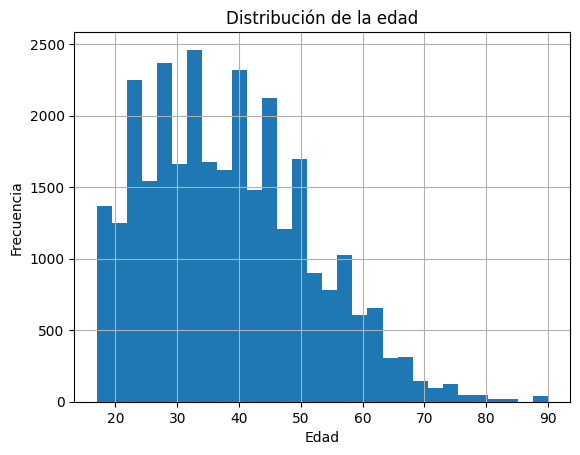

In [98]:
df_recomendaciones["age"].hist(bins=30)
plt.title("Distribución de la edad")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

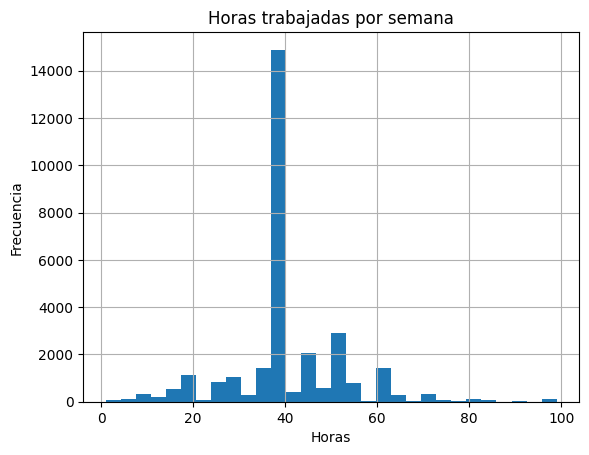

In [99]:
df_recomendaciones["hours.per.week"].hist(bins=30)
plt.title("Horas trabajadas por semana")
plt.xlabel("Horas")
plt.ylabel("Frecuencia")
plt.show()

# Análisis bivariado (Ingreso vs variables clave)

In [100]:
pd.crosstab(df_recomendaciones["education"], df_recomendaciones["income"])

income,<=50K,>50K
education,,
10th,761,59
11th,989,59
12th,348,29
1st-4th,145,6
5th-6th,276,12
7th-8th,522,35
9th,430,25
Assoc-acdm,752,256
Assoc-voc,963,344


In [101]:
pd.crosstab(df_recomendaciones["education"], df_recomendaciones["income"], normalize="index")

income,<=50K,>50K
education,,
10th,0.928049,0.071951
11th,0.943702,0.056298
12th,0.923077,0.076923
1st-4th,0.960265,0.039735
5th-6th,0.958333,0.041667
7th-8th,0.937163,0.062837
9th,0.945055,0.054945
Assoc-acdm,0.746032,0.253968
Assoc-voc,0.736802,0.263198


In [102]:
pd.crosstab(df_recomendaciones["sex"], df_recomendaciones["income"], normalize="index")

income,<=50K,>50K
sex,,
Female,0.886322,0.113678
Male,0.686163,0.313837


In [103]:
df_recomendaciones.groupby("income")["hours.per.week"].mean()

income
<=50K    39.348592
>50K     45.706580
Name: hours.per.week, dtype: float64

In [104]:
corr_matrix = df_recomendaciones[num_cols].corr()
corr_matrix

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
age,1.000000,-0.076511,0.043526,0.080154,0.060165,0.101599
fnlwgt,-0.076511,1.000000,-0.044992,0.000422,-0.009750,-0.022886
education.num,0.043526,-0.044992,1.000000,0.124416,0.079646,0.152522
capital.gain,0.080154,0.000422,0.124416,1.000000,-0.032229,0.080432
capital.loss,0.060165,-0.009750,0.079646,-0.032229,1.000000,0.052417
hours.per.week,0.101599,-0.022886,0.152522,0.080432,0.052417,1.000000


# guardado

In [106]:
with open("adult_census_clean.pkl", "wb") as f:
    dump(df_recomendaciones, f)